In [1]:
!pip install torch torchvision pandas numpy pillow scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to your dataset on Google Drive
# Adjust this path based on where dummy_dataset is located in your Drive
base_path = "/content/drive/MyDrive/final_dataset"

# Verify the structure
!ls "{base_path}/train/"
# Should show annotation.csv and image files like frame196_jpg.rf...jpg

Mounted at /content/drive
_annotations.csv
frame1000_jpg.rf.5ed5724c10ee1af5aa8a7f20baa910d6.jpg
frame1001_jpg.rf.4596efbc266b42f3365a6e18fbd402f8.jpg
frame1003_jpg.rf.30535d6d67bcf0442a43a0964e08ab3a.jpg
frame1004_jpg.rf.70e55ede84a57e7f7eca6151fd008502.jpg
frame1005_jpg.rf.b1311dfd2e2e637da5d50cbedcdfa463.jpg
frame1006_jpg.rf.2899adb94638e055b7474b01c2019ba5.jpg
frame1007_jpg.rf.1d57b6d47257109acd39d57aecf56338.jpg
frame1008_jpg.rf.ffda08fd836729398784c290c9823b26.jpg
frame1009_jpg.rf.83ad2a68a5d60b8e30dddc3df8ccc271.jpg
frame1010_jpg.rf.f1fa1a0799f5f4371b8eca21c4c788d0.jpg
frame1014_jpg.rf.4a862b5928e51392b30b1ab14bbe9222.jpg
frame1015_jpg.rf.3aeda83715808b0b992cd9a29c9cfed6.jpg
frame1016_jpg.rf.6c2e15bbf1d3568cc24b195ca0d4ca4e.jpg
frame1018_jpg.rf.6731793fb36244bef392f5882fe5e58b.jpg
frame1019_jpg.rf.1a6051004aff6428c7ee8a0a94e7cfbb.jpg
frame1020_jpg.rf.0b84ec1e860f00e1d06869e5545263a4.jpg
frame1022_jpg.rf.93d2b0136825e43e6cf1e38b16757cba.jpg
frame1024_jpg.rf.5cb3e32c3186ee10e4e2da

In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

class LunarDataset(Dataset):
    def __init__(self, root_dir, csv_file, transforms=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transforms = transforms
        self.imgs = list(sorted(self.annotations["filename"].unique()))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root_dir, img_name)
        try:
            if not os.path.exists(img_path):
                img = Image.new("RGB", (640, 640), color=(0, 0, 0))
                target = {
                    "boxes": torch.empty((0, 4), dtype=torch.float32),
                    "labels": torch.empty((0,), dtype=torch.int64),
                    "image_id": torch.tensor([idx]),
                    "area": torch.tensor([]),
                    "iscrowd": torch.empty((0,), dtype=torch.int64)
                }
            else:
                img = Image.open(img_path).convert("RGB")
                annots = self.annotations[self.annotations["filename"] == img_name]
                boxes = []
                labels = []
                for _, row in annots.iterrows():
                    class_name = row["class"]
                    if class_name in ["Crater", "Boulder"]:
                        boxes.append([row["xmin"], row["ymin"], row["xmax"], row["ymax"]])
                        labels.append(1 if class_name == "Crater" else 2)

                boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.empty((0, 4), dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.empty((0,), dtype=torch.int64)
                image_id = torch.tensor([idx])
                area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 else torch.tensor([])
                iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

                target = {
                    "boxes": boxes,
                    "labels": labels,
                    "image_id": image_id,
                    "area": area,
                    "iscrowd": iscrowd
                }
        except Exception as e:
            img = Image.new("RGB", (640, 640), color=(0, 0, 0))
            target = {
                "boxes": torch.empty((0, 4), dtype=torch.float32),
                "labels": torch.empty((0,), dtype=torch.int64),
                "image_id": torch.tensor([idx]),
                "area": torch.tensor([]),
                "iscrowd": torch.empty((0,), dtype=torch.int64)
            }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

def get_transform(train):
    transforms = [T.ToTensor()]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Custom collate function for robust batching
def custom_collate_fn(batch):
    images = []
    targets = []
    for item in batch:
        if item is None or len(item) != 2:
            continue
        img, target = item
        images.append(img)
        targets.append(target)
    if not images or not targets:
        raise ValueError("Empty batch after filtering")
    return images, targets

# Load dataset from Google Drive
base_path = "/content/drive/MyDrive/final_dataset"
train_dataset = LunarDataset(
    root_dir=os.path.join(base_path, "train"),
    csv_file=os.path.join(base_path, "train", "_annotations.csv"),
    transforms=get_transform(train=True)
)
valid_dataset = LunarDataset(
    root_dir=os.path.join(base_path, "valid"),
    csv_file=os.path.join(base_path, "valid", "_annotations.csv"),
    transforms=get_transform(train=False)
)
test_dataset = LunarDataset(
    root_dir=os.path.join(base_path, "test"),
    csv_file=os.path.join(base_path, "test", "_annotations.csv"),
    transforms=get_transform(train=False)
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate_fn)

In [4]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import numpy as np

# Set up model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 3  # Crater, Boulder, Background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Running on: {device}")

# Function to compute IoU
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_g, y1_g, x2_g, y2_g = box2
    xi1 = max(x1, x1_g)
    yi1 = max(y1, y1_g)
    xi2 = min(x2, x2_g)
    yi2 = min(y2, y2_g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_g - x1_g) * (y2_g - y1_g)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Function to compute accuracy
def compute_accuracy(preds, targets, iou_threshold=0.5):
    total = 0
    correct = 0
    for pred, target in zip(preds, targets):
        pred_boxes = pred["boxes"].cpu().numpy()
        pred_labels = pred["labels"].cpu().numpy()
        pred_scores = pred["scores"].cpu().numpy()
        gt_boxes = target["boxes"].cpu().numpy()
        gt_labels = target["labels"].cpu().numpy()

        mask = pred_scores > 0.5
        pred_boxes = pred_boxes[mask]
        pred_labels = pred_labels[mask]

        matched_gt = set()
        for p_box, p_label in zip(pred_boxes, pred_labels):
            best_iou = 0
            best_gt_idx = -1
            for gt_idx, (g_box, g_label) in enumerate(zip(gt_boxes, gt_labels)):
                if gt_idx in matched_gt:
                    continue
                if p_label == g_label:
                    iou = compute_iou(p_box, g_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gt_idx
            if best_iou >= iou_threshold:
                correct += 1
                matched_gt.add(best_gt_idx)
        total += len(gt_labels)
    return correct / total if total > 0 else 0

# Training and evaluation function
def train_and_evaluate(model, train_loader, test_loader, device, num_epochs=15):
    optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                                lr=0.005, momentum=0.9, weight_decay=0.0005)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, targets in train_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            train_loss += losses.item()

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        model.eval()
        with torch.no_grad():
            preds = model(images)  # Inference only
            train_acc = compute_accuracy(preds, targets)
            train_accuracies.append(train_acc)

        test_loss = 0
        for images, targets in test_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            with torch.no_grad():  # Inference for accuracy
                preds = model(images)
            model.train()  # Switch to train mode for loss
            loss_dict = model(images, targets)  # Compute loss
            losses = sum(loss for loss in loss_dict.values())
            test_loss += losses.item()
            model.eval()  # Switch back to eval mode
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        with torch.no_grad():
            preds = model(images)  # Inference only
            test_acc = compute_accuracy(preds, targets)
            test_accuracies.append(test_acc)

        model.train()  # Reset for next epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

# Run training
train_losses, test_losses, train_accuracies, test_accuracies = train_and_evaluate(model, train_loader, test_loader, device, num_epochs=15)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 79.0MB/s]


Running on: cuda
Epoch 1/15, Train Loss: 1.6325, Test Loss: 1.1482, Train Acc: 0.8627, Test Acc: 0.6739
Epoch 2/15, Train Loss: 1.0233, Test Loss: 1.0172, Train Acc: 0.9070, Test Acc: 0.6304
Epoch 3/15, Train Loss: 0.7526, Test Loss: 0.9163, Train Acc: 0.8200, Test Acc: 0.7609
Epoch 4/15, Train Loss: 0.6219, Test Loss: 0.8839, Train Acc: 0.9070, Test Acc: 0.7391
Epoch 5/15, Train Loss: 0.5883, Test Loss: 0.8962, Train Acc: 0.9767, Test Acc: 0.7826
Epoch 6/15, Train Loss: 0.5278, Test Loss: 0.9275, Train Acc: 0.9756, Test Acc: 0.7826
Epoch 7/15, Train Loss: 0.5212, Test Loss: 0.9907, Train Acc: 1.0000, Test Acc: 0.7826
Epoch 8/15, Train Loss: 0.4798, Test Loss: 0.9470, Train Acc: 0.9375, Test Acc: 0.7609
Epoch 9/15, Train Loss: 0.5044, Test Loss: 0.9724, Train Acc: 1.0000, Test Acc: 0.7826
Epoch 10/15, Train Loss: 0.4574, Test Loss: 0.9655, Train Acc: 0.9333, Test Acc: 0.7609
Epoch 11/15, Train Loss: 0.4220, Test Loss: 0.9233, Train Acc: 1.0000, Test Acc: 0.7609
Epoch 12/15, Train Loss:

Model saved to /content/drive/MyDrive/final_dataset/faster_rcnn_lunar11.pth


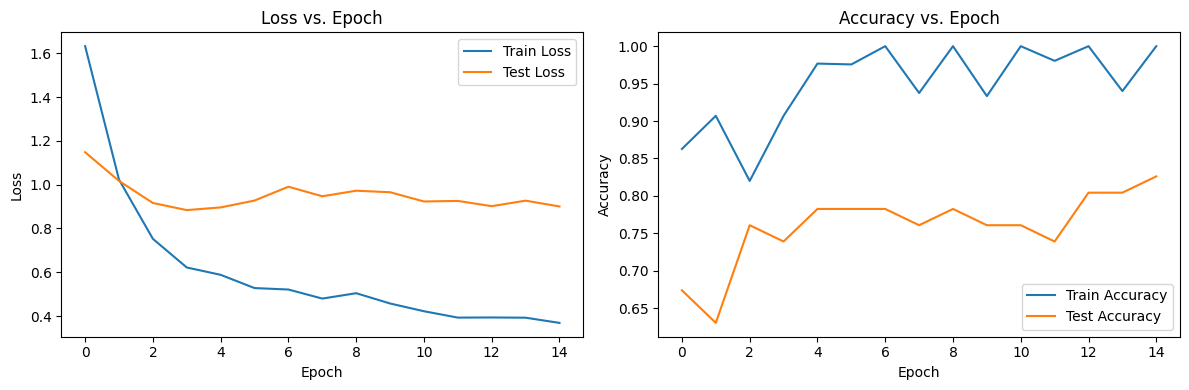

Classification Report:
              precision    recall  f1-score   support

      Crater       1.00      0.83      0.91       189
     Boulder       0.96      0.68      0.79        40

   micro avg       0.99      0.80      0.89       229
   macro avg       0.98      0.75      0.85       229
weighted avg       0.99      0.80      0.89       229

Overall Model Accuracy: 0.8035


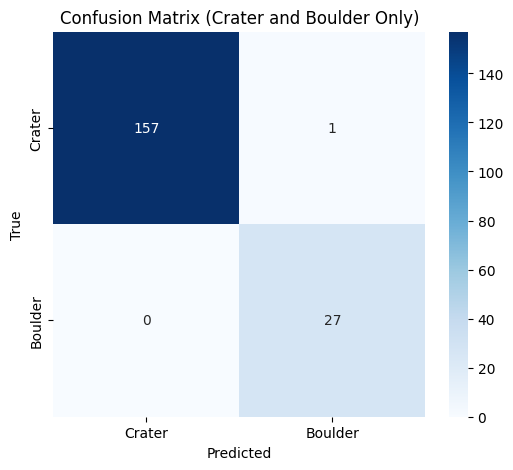

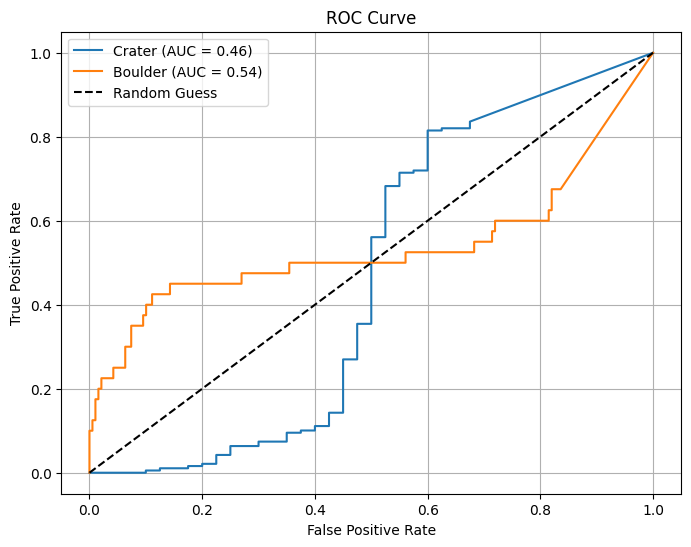

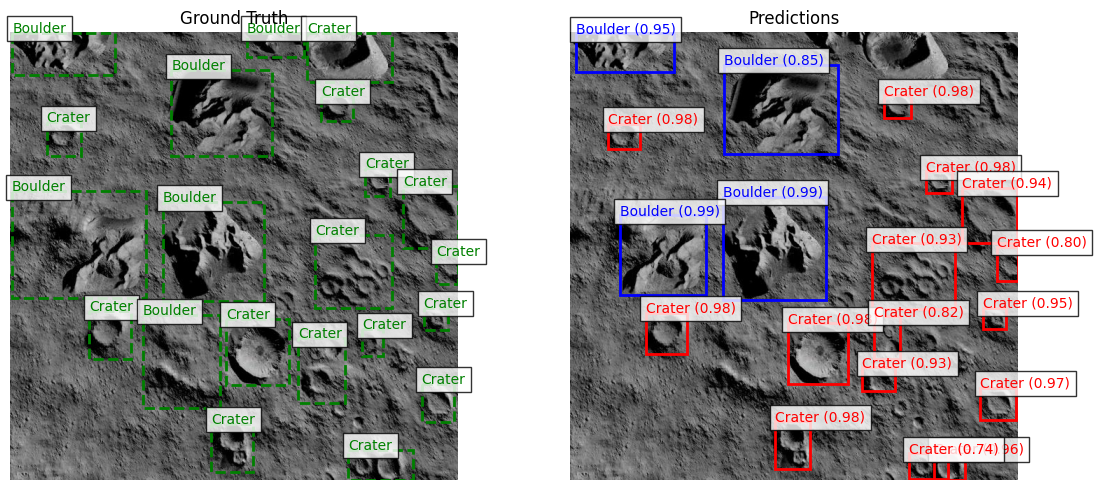

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import torch
import os

# Save the model
model_path = "/content/drive/MyDrive/final_dataset/faster_rcnn_lunar11.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot training and test loss/accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set and generate classification report
model.eval()
all_preds = []
all_labels = []
all_scores = []  # For ROC/AUC
with torch.no_grad():
    for images, targets in test_loader:
        images = list(img.to(device) for img in images)
        preds = model(images)
        for pred, target in zip(preds, targets):
            pred_labels = pred["labels"].cpu().numpy()
            pred_scores = pred["scores"].cpu().numpy()
            gt_labels = target["labels"].cpu().numpy()

            # Filter predictions by confidence threshold for classification report
            mask = pred_scores > 0.5
            pred_labels_filtered = pred_labels[mask]

            # Match predictions to ground truth using IoU
            pred_boxes = pred["boxes"].cpu().numpy()[mask]
            gt_boxes = target["boxes"].cpu().numpy()
            matched_preds = []

            if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                for gt_idx, gt_box in enumerate(gt_boxes):
                    best_iou = 0
                    best_pred_idx = -1
                    for pred_idx, pred_box in enumerate(pred_boxes):
                        iou = compute_iou(pred_box, gt_box)
                        if iou > 0.5 and iou > best_iou:
                            best_iou = iou
                            best_pred_idx = pred_idx
                    if best_pred_idx >= 0:
                        matched_preds.append(pred_labels[best_pred_idx])
                    else:
                        matched_preds.append(0)  # Missed detection = background
            else:
                matched_preds = [0] * len(gt_labels)  # No predictions, all missed

            # Ensure lengths match ground truth
            if len(matched_preds) < len(gt_labels):
                matched_preds.extend([0] * (len(gt_labels) - len(matched_preds)))
            elif len(matched_preds) > len(gt_labels):
                matched_preds = matched_preds[:len(gt_labels)]

            all_preds.extend(matched_preds)
            all_labels.extend(gt_labels)
            # Store scores for ROC
            matched_scores = []
            if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                for gt_idx, gt_box in enumerate(gt_boxes):
                    best_iou = 0
                    best_score = 0
                    for pred_idx, pred_box in enumerate(pred_boxes):
                        iou = compute_iou(pred_box, gt_box)
                        if iou > 0.5 and iou > best_iou:
                            best_iou = iou
                            best_score = pred_scores[pred_idx]
                    matched_scores.append(best_score if best_iou > 0.5 else 0)
            else:
                matched_scores = [0] * len(gt_labels)
            if len(matched_scores) < len(gt_labels):
                matched_scores.extend([0] * (len(gt_labels) - len(matched_scores)))
            elif len(matched_scores) > len(gt_labels):
                matched_scores = matched_scores[:len(gt_labels)]
            all_scores.extend(matched_scores)

# Generate classification report and overall accuracy
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Crater", "Boulder"], labels=[1, 2]))
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Model Accuracy: {overall_accuracy:.4f}")

# Compute and plot confusion matrix (excluding Background)
cm = confusion_matrix(all_labels, all_preds, labels=[1, 2])  # Only Crater and Boulder
plt.figure(figsize=(6, 5))  # Smaller figure for 2x2 matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Crater", "Boulder"],
            yticklabels=["Crater", "Boulder"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Crater and Boulder Only)")
plt.show()

# Compute and plot ROC curve and AUC for each class (Crater and Boulder)
plt.figure(figsize=(8, 6))
for class_id, class_name in zip([1, 2], ["Crater", "Boulder"]):
    # Binarize labels for one-vs-rest
    binary_labels = [1 if label == class_id else 0 for label in all_labels]
    fpr, tpr, _ = roc_curve(binary_labels, all_scores)
    auc_score = roc_auc_score(binary_labels, all_scores)

    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Define IoU function
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_g, y1_g, x2_g, y2_g = box2
    xi1 = max(x1, x1_g)
    yi1 = max(y1, y1_g)
    xi2 = min(x2, x2_g)
    yi2 = min(y2, y2_g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_g - x1_g) * (y2_g - y1_g)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Visualize ground truth and predictions in two separate images
def plot_ground_truth_and_prediction(images, preds, targets, idx=0):
    img = images[idx].cpu().permute(1, 2, 0).numpy()

    # Create two subplots side by side
    plt.figure(figsize=(12, 5))

    # Ground truth image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    for box, label in zip(targets[idx]["boxes"], targets[idx]["labels"]):
        box = box.cpu().numpy()
        plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                          fill=False, edgecolor="green", linewidth=2, linestyle="--"))
        plt.text(box[0], box[1], f"{'Crater' if label == 1 else 'Boulder'}",
                 color="green", bbox=dict(facecolor="white", alpha=0.8))
    plt.title("Ground Truth")
    plt.axis("off")

    # Predicted image
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    for box, label, score in zip(preds[idx]["boxes"], preds[idx]["labels"], preds[idx]["scores"]):
        if score > 0.5:
            box = box.cpu().numpy()
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                              fill=False, edgecolor="red" if label == 1 else "blue", linewidth=2))
            plt.text(box[0], box[1], f"{'Crater' if label == 1 else 'Boulder'} ({score:.2f})",
                     color="red" if label == 1 else "blue", bbox=dict(facecolor="white", alpha=0.8))
    plt.title("Predictions")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize a sample from the test set
images, targets = next(iter(test_loader))
with torch.no_grad():
    preds = model(list(img.to(device) for img in images))
plot_ground_truth_and_prediction(images, preds, targets, idx=0)